## 第11組 社群媒體分析期末專案(醫電公司產學合作)
組員: <br>
M104020018 朱淓璘 <br>
M104020011 王培碩 <br>
M104020038 蕭清耀 <br>
M104020029 邱承漢 <br>

## 任務目標(醫電公司提供)

1. 將所有國數字轉為阿拉伯數字表示(包含進位與小數點的表示) 

2. 根據前後文判斷是否轉為阿拉伯數字；醫電提供關鍵字表格判斷是否轉為阿拉伯數字的情況，包含前贅詞(數值欄位名稱)或後贅詞(單位)。
例如：第一次看診(國數字)、住院兩週(國數字)、血壓117(阿拉伯數字)、床號1508(阿拉伯數字)

## 想法: 
我們組別經過討論後，發想出兩種解決方案

1. 用字典法比對關鍵字附近的詞彙，來決定是否需要將其關鍵字做國數字轉換。 (簡單)
2. 用Bert進行Token級別的分類，訓練出一個分類器，能夠直接標註每個應該要被轉換的\<token> (困難、不確定性高)
    
- 雖然使用Bert是很熱門的技術，但因為醫電公司未提供相關的訓練資料，且資料集相當雜亂，我們可能會需要花大量的時間在資料集的整理及標註。也無法確定使用這種方式的效果是否更加優秀，似乎有點殺雞用牛刀的感覺。再者，我們也沒有找到"中文的"醫學相關的bert預訓練權重。所以我們最後決定採用可行性較高的方案1作為我們的解決方案

## 實作:
- 將原始文本進行斷句
- 將句子進行斷詞
- 藉由字典法關鍵字比對的方式，為每個句子計算轉換分數
- 如果國數字前後附近的詞，屬於正面(應轉換)的詞，就將句子中的國數字進行轉換

In [1]:
# 移除警告語"
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
import os
row_data_path = r'C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容'

import jieba
from sklearn.model_selection import train_test_split
from sklearn import metrics, model_selection, feature_extraction
from sklearn import feature_extraction, model_selection, naive_bayes,pipeline,\
manifold, preprocessing, feature_selection, metrics, svm, tree, ensemble
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
#pip install ipywidgets

## 匯入資料(txt)
醫電公司提供的逐字稿文檔皆為docx檔，我們在使用時先將其轉換成txt檔後直接輸入。

In [3]:
from pathlib import Path

pathlist = Path(row_data_path).glob('**/*.txt')
all_txt = [] 
for path in pathlist:
    all_txt.append(str(path))
    print(path)

C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\1970.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\1975.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\1980.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\1984.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\1985.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\1988.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\1996.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\2001.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\2030.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\2032.docx.txt
C:\Users\USER\Jupyter Notebook Project\社群媒體分析\Final_Project\raw_data\逐字稿內容\2035.docx.txt
C:\Users\USER\Jupyter

In [4]:
MetaData = pd.DataFrame(columns=['text'])
for path in all_txt:
    new_Data = pd.read_csv(path ,header=None, encoding='UTF-8')
    new_Data.columns = ['text']
    MetaData = MetaData.append(new_Data,ignore_index=True)
MetaData

,text
0,八七零二病歷號二一四八六四五 他是懷孕三五加五PROM twins c/s第一胎G one ...
1,現在是九月五號早上七點三十四分一六四三一九零五九六三 一六四五二一一四一二九 一六五一 一四...
2,欸大夜班交接班給白班 現在七點三十六分九月六號零三振翔 振翔早上有抽血今天的血都超難今天的血...
3,八七零一病歷號一七九九三三零 開始 他是三九加一in labor NSD第一胎的九月五號的十...
4,大夜交接班給白班九月七號七點三十九分一五零三 一七五七一一五振翔他說他昨天啊小夜班小夜班就一...
5,欸大夜班交接班給白班九月八號七點三十三分一五零一 他是obesity 的 說有高血壓跟糖尿病...
6,九月八號七點三十四分一六零二九六五四九零 一六零三二二七七零六 一六零五二一零二八二六 一六...
7,零一病歷號二一三零八九一他是雙測的輸卵管水腫 然後因為已婚六年沒有懷孕啦然後就來給江醫師看 ...
8,大夜班交接班給白班 七月十號七點四十分一五一八八九二七二七陳孰俄他是UTI跟APN的 他說病...
9,這個八七零一病歷號一二零六三五八這個子宮內膜增生的啦 九月十號的ATH vital sign...


## 資料清洗
在觀察資料後，發現該公司使用的Speech-to-Text模型在生成的逐字稿時，會將預測失敗的token輸出為"(?)"，該符號會影響我們處理資料，故將其刪除。

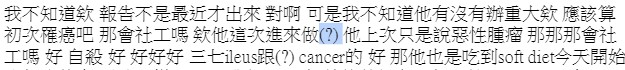

In [5]:
MetaData['text'] = MetaData.text.apply(lambda x: re.sub('\(|\?|\)|_|\s', '', x))

## 斷句
醫電公司提供的逐字稿文檔大致可以分成三種


(1) 逗號分隔句子 <br>
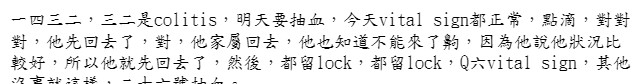

(2) 換行分隔句子 <br>
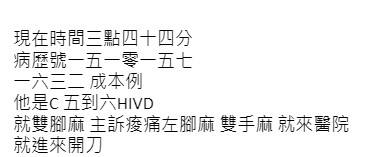

(3) 完全沒有分隔句子 <br>
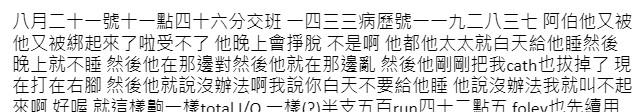

考慮到大部分的文本都沒有標點符號，為了保持通用性，我們採用Sliding Windows的方式分隔句子，句子長度設為20，每十個字切一段。

In [6]:
#pip install more_itertools

In [7]:
import more_itertools # Sliding windows的套件

# 斷詞 function -> Sliding Windows
def getSentence(row):
    
    seg_List = []
    seg_list = list(more_itertools.windowed(row, n=20, step=10, fillvalue=""))  # Sliding Windows
    for i in range(len(seg_list)):
        seg = "".join(list(seg_list[i]))
        #print(seg)
        seg_List.append(seg)
    return seg_List

# test sliding window
row = "病歷號二一四三六六五，他沒事，所以術後你也知道嗎" # EXAMPLE
getSentence(row)

['病歷號二一四三六六五，他沒事，所以術後你', '，他沒事，所以術後你也知道嗎']

In [8]:
# # 斷詞 function -> split('，|。|?|齁|啦')
# def getSentence(row):
#     seg_list = [row.split('，|。|?|齁|啦')] # 使用特殊字元或符號斷句
#     return seg_list

In [9]:
data = MetaData.copy()
data['sentence'] = data.text.progress_apply(getSentence)
data = data.explode('sentence').explode('sentence')
print(f"total sentences: {data.shape[0]}")
data.head(20)

  0%|          | 0/16 [00:00<?, ?it/s]

total sentences: 6391


,text,sentence
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,八七零二病歷號二一四八六四五他是懷孕三五
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,八六四五他是懷孕三五加五PROMtwin
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,加五PROMtwinsc/s第一胎Gon
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,sc/s第一胎GonePone九月三號的
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,ePone九月三號的c/s啦vitals
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,c/s啦vitalsign就Qfour身
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,ign就Qfour身上管路就剩左手二十二
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,上管路就剩左手二十二號的PCA反正我有因
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,號的PCA反正我有因為他今天開始吃止痛藥
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,為他今天開始吃止痛藥嘛我有問他要不要拔啦


### 結巴斷詞與整理

In [10]:
def load_stop_words(path):
    with open(path, encoding='UTF-8') as f:
        stopWords = [line.strip() for line in f.readlines()]
    return stopWords

def get_tokens(sent,user_dict,stop_dict):
    
    # 去除noise 斷詞
    jieba.load_userdict(user_dict) # 客製化字典    
    sent = re.sub('\W+', '', sent) # 過濾標點符號
    words = list(jieba.cut(sent)) # 斷詞

    #去除停用字
    stopWords = load_stop_words(stop_dict)    
    words = [w for w in words if w not in stopWords and len(w) > 1] # 字詞長度要>1
    return " ".join(words)

## 斷詞字典
我們使用搜狗詞庫中的醫學領域詞彙專業字典，並使用線上軟體將其從簡體中文轉為繁體中文
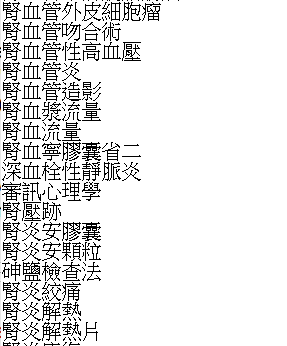

In [11]:
# 這裡會跑比較久
stop_path = 'dict/stopwords.txt'
user_path = "dict/medicine.txt" #醫學領域專用字典
#user_path = "dict/user_dict.txt"

# 把句子切開，待會丟DTM
data['clean_txt'] = data.progress_apply(lambda row : get_tokens(row['sentence'],user_path,stop_path), axis=1) 
data.head(5)

  0%|          | 0/6391 [00:00<?, ?it/s]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\USER\AppData\Local\Temp\jieba.cache
Loading model cost 0.870 seconds.
Prefix dict has been built successfully.


,text,sentence,clean_txt
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,八七零二病歷號二一四八六四五他是懷孕三五,八七 零二 病歷號 二一 四八 四五 懷孕 三五
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,八六四五他是懷孕三五加五PROMtwin,八六 四五 懷孕 五加 PROMtwin
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,加五PROMtwinsc/s第一胎Gon,加五 PROMtwinscs 第一胎 Gon
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,sc/s第一胎GonePone九月三號的,scs 第一胎 GonePone 九月 三號
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,ePone九月三號的c/s啦vitals,ePone 九月 三號 cs vitals


In [12]:
# 把字詞斷開，方便分析
token_df = data[['sentence','clean_txt']]
token_df["word"] = data["clean_txt"].str.split(" ") # 將句子用空白切成list
token_df = token_df[['sentence','word']].explode("word").reset_index(drop=True) # 把切開的list展開
token_df.head(5)

,sentence,word
0,八七零二病歷號二一四八六四五他是懷孕三五,八七
1,八七零二病歷號二一四八六四五他是懷孕三五,零二
2,八七零二病歷號二一四八六四五他是懷孕三五,病歷號
3,八七零二病歷號二一四八六四五他是懷孕三五,二一
4,八七零二病歷號二一四八六四五他是懷孕三五,四八


In [13]:
# 看看有幾個詞
print(f"unique words: {len(token_df.word.unique())}")

unique words: 5858


## 正負面分析
- 正面:要轉換國數字
- 負面:不轉換國數字



## 字典建立:
我們主要參考醫電公司提供的表格表頭，作為字典的建立詞彙
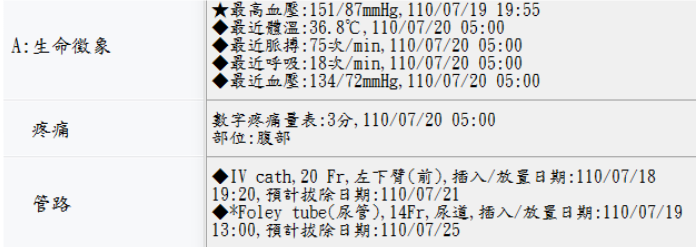

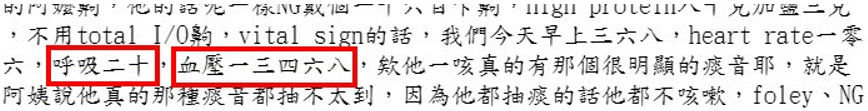

In [14]:
def load_senti():
    filepath = ['negative','positive']
    d_liwc = []
    for file in filepath:
        filename = f"./dict/wheather_trans/{file}.txt"
        with open(filename, 'r', encoding='UTF-8-sig') as f:
            d_liwc.append([f.read().split("\n"),file])
    df_liwc = pd.DataFrame(d_liwc,columns = ['word','sentiments']).explode('word',ignore_index = True)    
    df_liwc['word'] = df_liwc['word'].str.replace(r'\n','')
    
    return df_liwc

In [15]:
# 獲得情緒字典
data_trans_dict = load_senti() 

# 新增的負面詞
neg_added = [] 
for w in neg_added:
    data_trans_dict.loc[-1] = [w, "negative"]
    data_trans_dict.index = data_trans_dict.index + 1
    data_trans_dict = data_trans_dict.sort_index()

D:\Anaconda3\envs\Social_Media_Analytics\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [16]:
# 看一下需要轉換的國數字的相關詞
temp = data_trans_dict[data_trans_dict['sentiments']=='positive'].head()
temp

,word,sentiments
35,床號,positive
36,血壓,positive
37,高危險群,positive
38,total I/O,positive
39,I/O,positive


In [17]:
# 看一下不需要轉換的國數字的相關詞
temp = data_trans_dict[data_trans_dict['sentiments']=='negative'].head()
temp

,word,sentiments
0,看診,negative
1,住院,negative
2,兩週,negative
3,三週,negative
4,四週,negative


In [18]:
# 統計文章情緒
senti_df = pd.merge(token_df, data_trans_dict, on=['word'],how='inner') # token和情緒字典做merge
senti_count = senti_df.groupby(['sentence','sentiments'],as_index=False).size() # 算出每篇文章的情緒
senti_count = senti_count.pivot(index='sentence',columns='sentiments',values='size').fillna(0) # 把資料展開，缺值補零
senti_count = senti_count.reset_index().rename_axis(None, axis=1) # 把兩個level變成一層level

# 幫文章加上標籤
senti_count['label'] = np.where(senti_count['positive'] >= senti_count['negative'], 'pos','neg')
senti_count

,sentence,negative,positive,label
0,/s過三次啦十年前左肩膀車禍開過刀兩年前,1.0,0.0,neg
1,B三價然後bacteria也三價血壓的話,0.0,2.0,pos
2,CR啦昨天住院然後今天開刀就回去了vit,1.0,0.0,neg
3,C掉就不用吃了喔啊多開一顆促尿尿的啊ga,0.0,1.0,pos
4,D有住過stent放過三支給劉彥廷放的啊,0.0,1.0,pos
...,...,...,...,...
407,齁他其實他是我們他是帶一顆bid但是他其,0.0,1.0,pos
408,齁他的話之前痔瘡有開過刀血壓都還ok一二,0.0,2.0,pos
409,齁先不要丟就這樣啊這是昨天ICP才十cc,0.0,1.0,pos
410,齁右下一支cath到期抽血沒有新的吧你應,0.0,1.0,pos


In [19]:
# token和情緒字典做merge
data_senti = pd.merge(data, senti_count[['sentence','label']], on=['sentence'],how='left').fillna('pos') 
data_senti.head(5)

,text,sentence,clean_txt,label
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,八七零二病歷號二一四八六四五他是懷孕三五,八七 零二 病歷號 二一 四八 四五 懷孕 三五,pos
1,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,八六四五他是懷孕三五加五PROMtwin,八六 四五 懷孕 五加 PROMtwin,pos
2,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,加五PROMtwinsc/s第一胎Gon,加五 PROMtwinscs 第一胎 Gon,pos
3,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,sc/s第一胎GonePone九月三號的,scs 第一胎 GonePone 九月 三號,pos
4,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,ePone九月三號的c/s啦vitals,ePone 九月 三號 cs vitals,pos


In [20]:
fliter = (data_senti["label"] == "pos")
data_pos = data_senti[fliter]

fliter = (data_senti["label"] != "pos")
data_neg = data_senti[fliter]

data_pos

,text,sentence,clean_txt,label
0,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,八七零二病歷號二一四八六四五他是懷孕三五,八七 零二 病歷號 二一 四八 四五 懷孕 三五,pos
1,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,八六四五他是懷孕三五加五PROMtwin,八六 四五 懷孕 五加 PROMtwin,pos
2,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,加五PROMtwinsc/s第一胎Gon,加五 PROMtwinscs 第一胎 Gon,pos
3,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,sc/s第一胎GonePone九月三號的,scs 第一胎 GonePone 九月 三號,pos
4,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,ePone九月三號的c/s啦vitals,ePone 九月 三號 cs vitals,pos
...,...,...,...,...
6386,九月十四號晚上十一點五十一分一五零一床病歷號五一零四五六徐李燕吧李燕這個欸L五到Sone脊椎...,好像就這樣就是小放電這樣子Qidvita,小放電 這樣子 Qidvita,pos
6387,九月十四號晚上十一點五十一分一五零一床病歷號五一零四五六徐李燕吧李燕這個欸L五到Sone脊椎...,這樣子Qidvitalsign齁七十五p,這樣子 Qidvitalsign 七十五,pos
6388,九月十四號晚上十一點五十一分一五零一床病歷號五一零四五六徐李燕吧李燕這個欸L五到Sone脊椎...,lsign齁七十五percent十五li,lsign 七十五 percent 十五 li,pos
6389,九月十四號晚上十一點五十一分一五零一床病歷號五一零四五六徐李燕吧李燕這個欸L五到Sone脊椎...,ercent十五liter喔齁I/O沒事,ercent 十五 liter IO 沒事,pos


In [21]:
#pip install cn2an --ignore-installed ruamel.yaml --user

In [22]:
import cn2an # 國數字轉數字套件

# 查看版本
#print(cn2an.__version__)


str1 = "病歷號二零一四三六六五好jo4 四十三123哈哈是" # Example
  
pattern=r"(零|一|二|三|四|五|六|七|八|九|十|百|千|萬|十萬|百萬)+"

for match in re.finditer(pattern, str1):
    str1 = str1.replace(match.group(), str(cn2an.cn2an(match.group(), "normal")))
print(str1)


病歷號20143665好jo4 43123哈哈是


In [23]:

def Transform(row):
    
    pattern=r"(零|一|二|三|四|五|六|七|八|九|十|百|千|萬|十萬|百萬)+"
    
    for match in re.finditer(pattern, row):
        try:
            row = row.replace(match.group(), str(cn2an.cn2an(match.group(), "normal")))
        except ValueError:
            pass  # do nothing!
        
    #print(row)

    return row
    

In [24]:
data_pos['transform'] = data_pos.sentence.progress_apply(Transform)
data_neg['transform'] = data_neg.sentence

  0%|          | 0/6329 [00:00<?, ?it/s]

D:\Anaconda3\envs\Social_Media_Analytics\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\envs\Social_Media_Analytics\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
data = data_pos.append(data_neg)

In [26]:
data.to_csv("result.csv", index=False, encoding='utf_8_sig')

In [47]:
# 看一下轉換後的結果
trans = data[data['label']=='pos']
trans.sample(10)

,text,sentence,clean_txt,label,transform
2604,九月八號七點三十四分一六零二九六五四九零一六零三二二七七零六一六零五二一零二八二六一六零六九...,或妹妹之類的吧因為長蠻像的然後因為病人在,妹妹 然後因 病人,pos,或妹妹之類的吧因為長蠻像的然後因為病人在
5900,大夜白班交班時間七點三十六分一五一八九病歷號八九二七二七的阿姨沒事沒特別的血壓早上一四四八三...,一樣上五下四pupil二點五有light,五下 pupil 二點 五有 light,pos,1樣上5下4pupil2點5有light
3102,零一病歷號二一三零八九一他是雙測的輸卵管水腫然後因為已婚六年沒有懷孕啦然後就來給江醫師看因為...,就說留手背的好了因為他怕對啊但我又reo,手背 reo,pos,就說留手背的好了因為他怕對啊但我又reo
99,八七零二病歷號二一四八六四五他是懷孕三五加五PROMtwinsc/s第一胎GonePone九...,一五病歷號一八六零五零右側的ovaria,一五 病歷號 一八 六零 五零 右側 ovaria,pos,15病歷號186050右側的ovaria
2531,九月八號七點三十四分一六零二九六五四九零一六零三二二七七零六一六零五二一零二八二六一六零六九...,點硬度而已然後他說他說他之前就中風所以他,硬度 已然 中風,pos,點硬度而已然後他說他說他之前就中風所以他
1408,大夜交接班給白班九月七號七點三十九分一五零三一七五七一一五振翔他說他昨天啊小夜班小夜班就一直...,零三一七五七一一五振翔他說他昨天啊小夜班,零三 一七 五七一 一五 振翔 昨天 小夜班,pos,31757115振翔他說他昨天啊小夜班
2381,欸大夜班交接班給白班九月八號七點三十三分一五零一他是obesity的說有高血壓跟糖尿病影響反...,先生幫他換欸然後PCR他先生PCR沒事啊,他換 PCR PCR 沒事,pos,先生幫他換欸然後PCR他先生PCR沒事啊
4294,這個八七零一病歷號一二零六三五八這個子宮內膜增生的啦九月十號的ATHvitalsign就bi...,ur有告midnightNPO要用PCA,ur 有告 midnightNPO 要用 PCA,pos,ur有告midnightNPO要用PCA
2783,零一病歷號二一三零八九一他是雙測的輸卵管水腫然後因為已婚六年沒有懷孕啦然後就來給江醫師看因為...,近他有紋眉喔已經寫上去了然後是媽媽來陪他,經寫 了然 媽媽來,pos,近他有紋眉喔已經寫上去了然後是媽媽來陪他
1998,欸大夜班交接班給白班九月八號七點三十三分一五零一他是obesity的說有高血壓跟糖尿病影響反...,permit那些都sign好就在三民已經,permit sign 三民,pos,permit那些都sign好就在3民已經


In [28]:
# 看一下不用轉換的句子
org = data[data['label']=='neg']
org.sample(10)

,text,sentence,clean_txt,label,transform
3582,大夜班交接班給白班七月十號七點四十分一五一八八九二七二七陳孰俄他是UTI跟APN的他說病人左...,estxray第一次在急診室沒事第二次就,estxray 第一次 急診 沒事 第二次,neg,estxray第一次在急診室沒事第二次就
2772,零一病歷號二一三零八九一他是雙測的輸卵管水腫然後因為已婚六年沒有懷孕啦然後就來給江醫師看因為...,兩個地方做過試管都失敗兩次試管都失敗喔然,兩個 地方 做過 試管 失敗 兩次 試管 失敗,neg,兩個地方做過試管都失敗兩次試管都失敗喔然
1125,八七零一病歷號一七九九三三零開始他是三九加一inlaborNSD第一胎的九月五號的十一點四十...,九所以就進來手術住院啦然後過去病史的話就,手術 住院 然後過 病史,neg,九所以就進來手術住院啦然後過去病史的話就
6136,九月十四號晚上十一點五十一分一五零一床病歷號五一零四五六徐李燕吧李燕這個欸L五到Sone脊椎...,病人這一塊住院第七天第十四天都是公費的快,病人 這一塊 住院 第七天 第十四天 公費,neg,病人這一塊住院第七天第十四天都是公費的快
3597,大夜班交接班給白班七月十號七點四十分一五一八八九二七二七陳孰俄他是UTI跟APN的他說病人左...,stones所以他不需要OP住院治療就好,stones OP 住院 治療,neg,stones所以他不需要OP住院治療就好
3731,大夜班交接班給白班七月十號七點四十分一五一八八九二七二七陳孰俄他是UTI跟APN的他說病人左...,服還沒有穿但是在病房他目前就是全自費住院,服還 病房 全自費 住院,neg,服還沒有穿但是在病房他目前就是全自費住院
5140,今天是九月十三號下午十五點四十六分一來四五二一六七二一一六四六一零八五七五二一六四七一二一八...,今天想要兩三次我都給他丟下去兩張四u對啊,想要 三次 我都給 兩張,neg,今天想要兩三次我都給他丟下去兩張四u對啊
6172,九月十四號晚上十一點五十一分一五零一床病歷號五一零四五六徐李燕吧李燕這個欸L五到Sone脊椎...,只有第一次加六然後後面都加七後來我直接算,第一次 加六然後後面 加七後來,neg,只有第一次加六然後後面都加七後來我直接算
6213,九月十四號晚上十一點五十一分一五零一床病歷號五一零四五六徐李燕吧李燕這個欸L五到Sone脊椎...,y兩次齁先生的喔齁data出來了然後先生,兩次 data 了然,neg,y兩次齁先生的喔齁data出來了然後先生
5242,零一是你的嗎不是學姐我掰一五二八呂紹充病歷號一三五七七九六九月十三號晚上十一點五十分他的左邊...,的話CAD過他總共做了三次導管放了四隻s,CAD 過他 總共做 三次 導管,neg,的話CAD過他總共做了三次導管放了四隻s


## 3. 將資料切成訓練集與測試集
### 3.1 根據7:3的比例切分資料集
利用 sklearn 中的 train_test_split 函數將 `raw_data` 隨機切成 7:3，設置 random_state 讓每次切分的結果一致。`y_train`和`y_test`分別為訓練資料和測試資料的預測目標（每個句子所屬的書名id）。

In [29]:
# 把整個資料集七三切
dtf_train, dtf_test = model_selection.train_test_split(data_senti, stratify=data_senti["label"],
                                                       test_size=0.3, random_state=2021)
## get target
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [30]:
# 看一下各個資料集切分的比例，應該要一致
print(f"raw data percentage :\n{data_senti['label'].value_counts(normalize=True) * 100}")
print(f"\ntrain percentage :\n{dtf_train['label'].value_counts(normalize=True) * 100}")
print(f"\ntest percentage :\n{dtf_test['label'].value_counts(normalize=True) * 100}")

raw data percentage :
pos    99.029886
neg     0.970114
Name: label, dtype: float64

train percentage :
pos    99.038677
neg     0.961323
Name: label, dtype: float64

test percentage :
pos    99.009385
neg     0.990615
Name: label, dtype: float64


In [31]:
corpus = dtf_train["clean_txt"]

### 定義建模與畫圖的函數

In [32]:
def model_predict(train_data, test_data, train_label, vectorizer, classifier, return_classifier = False):
    
    start = time.time()

    # sentence to DTM
    vectorizer.fit(train_data) # fit(corpus)
    X_train = vectorizer.transform(corpus)    
    
    ## pipeline: 分類器 + 資料處理 vectorizer
    model = pipeline.Pipeline([("vectorizer", vectorizer),  
                               ("classifier", classifier)])
    ## train classifier
    model["classifier"].fit(X_train, train_label)
    
    ## test
    X_test = test_data.values
    predicted = model.predict(X_test)
    predicted_prob = model.predict_proba(X_test)
    
    end = time.time()
    print(f"time costing: {end - start}")
    
    if return_classifier:
        return predicted, predicted_prob, classifier       
    else:
        return predicted, predicted_prob

In [33]:
def evaluate(true, predicted, predicted_prob):

    classes = np.unique(true)
    true_array = pd.get_dummies(true, drop_first=False).values

    ## Accuracy, Precision, Recall
    Accuracy = metrics.accuracy_score(true, predicted)
    AUC = metrics.roc_auc_score(true_array, predicted_prob, 
                                multi_class="ovr")
    
    print("Accuracy:",  round(Accuracy,2))
    print("Auc:", round(AUC,2))
    print("Detail:")
    print(metrics.classification_report(true, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(true, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

    ## Plot roc
    roc_auc_dict = {}
    for i in range(len(classes)):
        fpr, tpr, thresholds = metrics.roc_curve(true_array[:,i],  
                               predicted_prob[:,i])
        roc_auc = metrics.auc(fpr, tpr)
        ax[0].plot(fpr, tpr, lw=3, 
                  label='{0} (area={1:0.2f})'.format(classes[i], roc_auc)
                   )
        roc_auc_dict[classes[i]] = {"fpr":fpr,"tpr": tpr, "roc_auc": roc_auc} 
        
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
              xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", 
              title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)

    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = metrics.precision_recall_curve(
                     true_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, 
                   label='{0} (area={1:0.2f})'.format(classes[i], 
                                      metrics.auc(recall, precision))
                  )
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
              ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
    return Accuracy, AUC, roc_auc_dict

### step 1 定義 vectorizer

In [34]:
cut_off = 0 # 經由實驗發現詞頻不篩模型會比較準，但需要較長的時間
vec_cv = feature_extraction.text.CountVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)
vec_tfidf = feature_extraction.text.TfidfVectorizer(max_features=10000, min_df = cut_off) # , ngram_range=(1,2)

### step 2 定義 classifier

In [35]:
cla_lg = LogisticRegression(multi_class='multinomial', solver='lbfgs')
cla_svc = svm.SVC(probability=True)
cla_rf  = ensemble.RandomForestClassifier()

### step 3 定義測試和訓練資料集

In [36]:
train_data = dtf_train["clean_txt"]
test_data = dtf_test["clean_txt"]
train_label = y_train
test_label = y_test

In [37]:
## 創造一個空的dataframe 和 list 存模型結果
result_df = pd.DataFrame(columns=['model_type', 'Accuracy', 'AUC'])
roc_auc_all = {}

### 5.1 Model Building : logistic regression

model type: CV + logistic regression
time costing: 0.41796135902404785
Accuracy: 0.99
Auc: 1.0
Detail:
              precision    recall  f1-score   support

         neg       0.89      0.42      0.57        19
         pos       0.99      1.00      1.00      1899

    accuracy                           0.99      1918
   macro avg       0.94      0.71      0.78      1918
weighted avg       0.99      0.99      0.99      1918



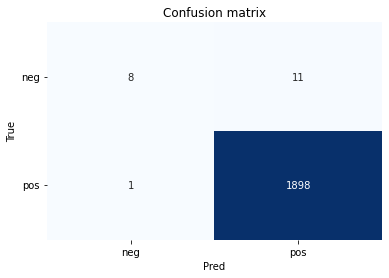

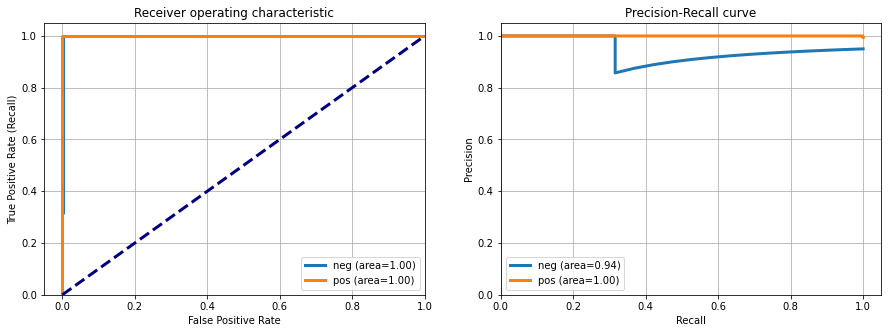

In [38]:
model_type = "CV + logistic regression"
print(f"model type: {model_type}")
# 訓練模型
pred_l , pred_pro_l, logisticRegr = model_predict(dtf_train["clean_txt"], dtf_test["clean_txt"], y_train,
                                 vectorizer = vec_cv, classifier = cla_lg,
                                 return_classifier = True)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred_l, pred_pro_l)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + logistic regression
time costing: 0.25020480155944824
Accuracy: 0.99
Auc: 1.0
Detail:
              precision    recall  f1-score   support

         neg       1.00      0.11      0.19        19
         pos       0.99      1.00      1.00      1899

    accuracy                           0.99      1918
   macro avg       1.00      0.55      0.59      1918
weighted avg       0.99      0.99      0.99      1918



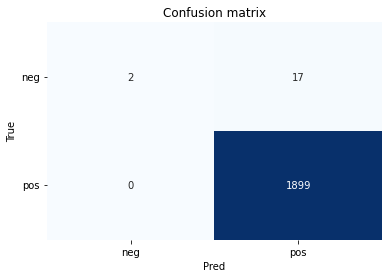

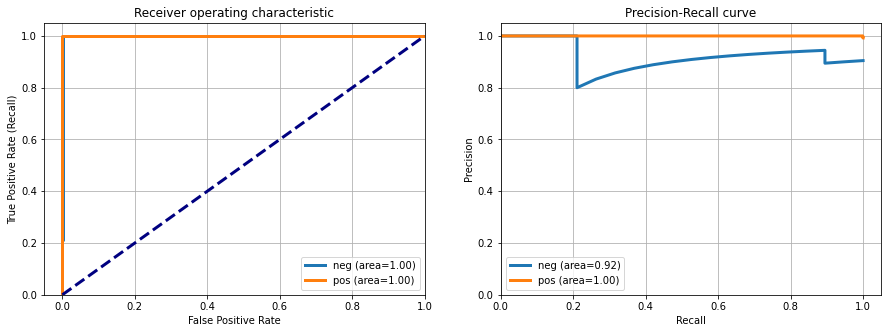

In [39]:
model_type = "TF-IDF + logistic regression"
print(f"model type: {model_type}")

# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf , classifier = cla_lg)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

### 5.2 Model Building : SVC

model type: CV + SVC
time costing: 4.037465810775757
Accuracy: 0.99
Auc: 1.0
Detail:
              precision    recall  f1-score   support

         neg       0.88      0.37      0.52        19
         pos       0.99      1.00      1.00      1899

    accuracy                           0.99      1918
   macro avg       0.93      0.68      0.76      1918
weighted avg       0.99      0.99      0.99      1918



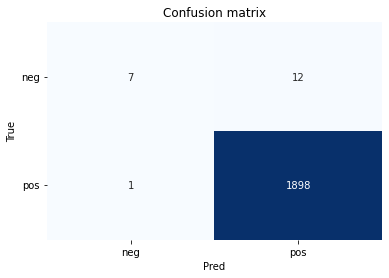

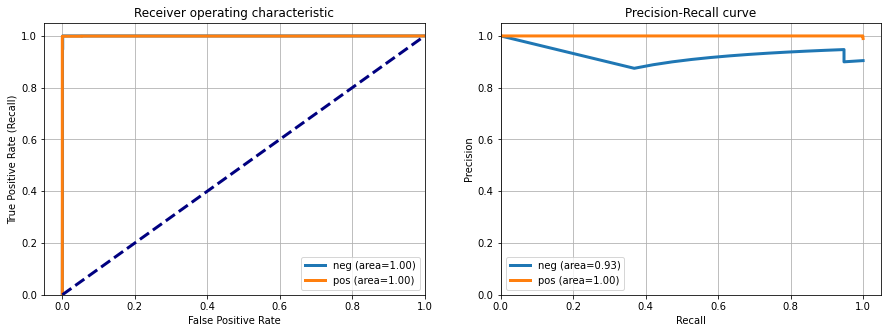

In [40]:
model_type = "CV + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + SVC
time costing: 4.434190273284912
Accuracy: 0.99
Auc: 1.0
Detail:
              precision    recall  f1-score   support

         neg       0.88      0.37      0.52        19
         pos       0.99      1.00      1.00      1899

    accuracy                           0.99      1918
   macro avg       0.93      0.68      0.76      1918
weighted avg       0.99      0.99      0.99      1918



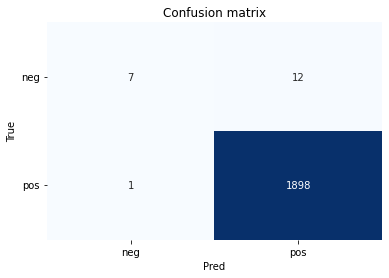

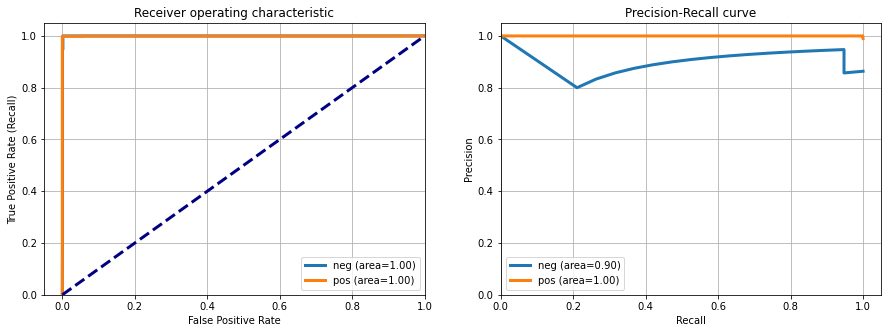

In [41]:
model_type = "TF-IDF + SVC"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_tfidf, classifier = cla_svc)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

## Model Building : RandomForest

model type: CV + RandomForest
time costing: 0.6845612525939941
Accuracy: 1.0
Auc: 1.0
Detail:
              precision    recall  f1-score   support

         neg       0.92      0.58      0.71        19
         pos       1.00      1.00      1.00      1899

    accuracy                           1.00      1918
   macro avg       0.96      0.79      0.85      1918
weighted avg       1.00      1.00      0.99      1918



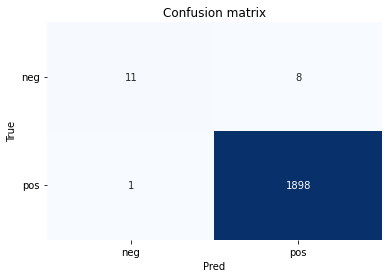

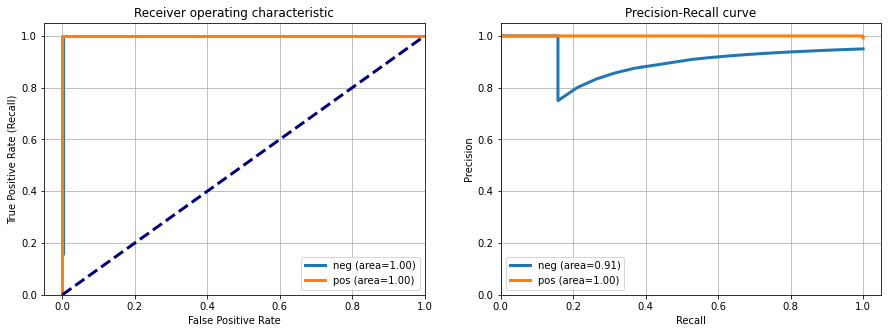

In [42]:
model_type = "CV + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data, test_data, train_label,
                             vectorizer = vec_cv, classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc

model type: TF-IDF + RandomForest
time costing: 0.7166938781738281
Accuracy: 1.0
Auc: 1.0
Detail:
              precision    recall  f1-score   support

         neg       0.92      0.58      0.71        19
         pos       1.00      1.00      1.00      1899

    accuracy                           1.00      1918
   macro avg       0.96      0.79      0.85      1918
weighted avg       1.00      1.00      0.99      1918



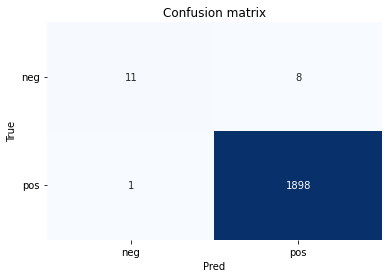

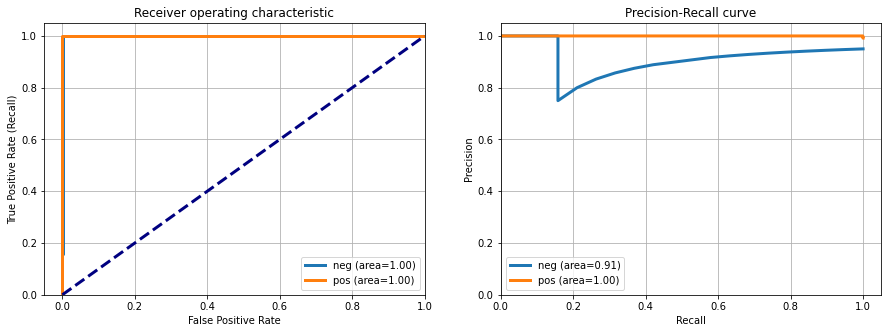

In [43]:
model_type = "TF-IDF + RandomForest"
print(f"model type: {model_type}")
# 訓練模型
pred , pred_pro = model_predict(train_data ,test_data ,train_label,
                             vectorizer = vec_tfidf ,classifier = cla_rf)
# 查看模型訓練結果
accuracy, auc, roc_auc = evaluate(test_label, pred, pred_pro)
# 把結果加進result_df
result_df = result_df.append({'model_type': model_type, 'Accuracy': accuracy, 'AUC': auc }
                             , ignore_index=True)
roc_auc_all[model_type] = roc_auc